In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src')
from models import LogisticRegressionGD, train_test_split, classification_report

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Load Preprocessed Data

In [2]:
# Load preprocessed training data
train_data = np.genfromtxt('../data/processed/train_processed.csv', delimiter=',', skip_header=1)

# Separate features and target
X_full = train_data[:, :-1]  
y_full = train_data[:, -1]    

print(f"Data loaded successfully!")
print(f"  Features shape: {X_full.shape}")
print(f"  Target shape: {y_full.shape}")
print(f"  Number of features: {X_full.shape[1]}")
print(f"\nTarget distribution:")
unique, counts = np.unique(y_full, return_counts=True)
for val, count in zip(unique, counts):
    pct = count / len(y_full) * 100
    print(f"  Class {int(val)}: {count:,} ({pct:.2f}%)")

Data loaded successfully!
  Features shape: (19158, 33)
  Target shape: (19158,)
  Number of features: 33

Target distribution:
  Class 0: 14,381 (75.07%)
  Class 1: 4,777 (24.93%)


## 2. Train/Validation Split

In [3]:
# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, shuffle=True, random_state=42
)
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Validation set: {X_val.shape[0]:,} samples")

# Check class distribution in train/val
print("\nTraining set distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique, counts):
    pct = count / len(y_train) * 100
    print(f"  Class {int(val)}: {count:,} ({pct:.2f}%)")

print("\nValidation set distribution:")
unique, counts = np.unique(y_val, return_counts=True)
for val, count in zip(unique, counts):
    pct = count / len(y_val) * 100
    print(f"  Class {int(val)}: {count:,} ({pct:.2f}%)")

  Training set: 15,326 samples
  Validation set: 3,832 samples

Training set distribution:
  Class 0: 11,476 (74.88%)
  Class 1: 3,850 (25.12%)

Validation set distribution:
  Class 0: 2,905 (75.81%)
  Class 1: 927 (24.19%)


## Như đã đề cập, vì dataset mất cân bằng ở hai tập target và no-target do đó nên có phương án đề xuất như sau:
1. Tất cả samples đều có trọng số bằng nhau khi tính loss
2. Vì class 1 thiểu số nên được gán weight cao hơn từ 2-3 lần để đóng góp tương đương vào tổng loss

## 3. Baseline Model (No Class Weights)

In [4]:
baseline_model = LogisticRegressionGD(
    learning_rate=0.1,
    epochs=1000,
    l2_reg=0.01,
    tolerance=1e-6
)

baseline_model.fit(X_train, y_train)

# Training metrics
train_probs = baseline_model.predict_proba(X_train)
train_preds = baseline_model.predict(X_train)
train_metrics = classification_report(y_train, train_preds, train_probs)

print("\nTraining Metrics:")
for metric, value in train_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

# Validation metrics
val_probs = baseline_model.predict_proba(X_val)
val_preds = baseline_model.predict(X_val)
val_metrics = classification_report(y_val, val_preds, val_probs)

print("\nValidation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

print(f"\nTraining completed in {len(baseline_model.history.losses)} epochs")


Training Metrics:
  Accuracy: 0.7712
  Precision: 0.5901
  Recall: 0.2925
  F1: 0.3911
  Log_loss: 0.4699

Validation Metrics:
  Accuracy: 0.7740
  Precision: 0.5645
  Recall: 0.2880
  F1: 0.3814
  Log_loss: 0.4756

Training completed in 1000 epochs


## 4. Balanced Model (With Class Weights)

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
class_weights = {}
for cls, count in zip(unique, counts):
    class_weights[cls] = len(y_train) / (len(unique) * count)

print("\nClass weights calculated:")
for cls, weight in class_weights.items():
    print(f"  Class {int(cls)}: {weight:.4f}")

# Train balanced model
balanced_model = LogisticRegressionGD(
    learning_rate=0.1,
    epochs=1000,
    l2_reg=0.01,
    tolerance=1e-6,
    class_weight=class_weights
)

balanced_model.fit(X_train, y_train)

# Training metrics
train_probs_bal = balanced_model.predict_proba(X_train)
train_preds_bal = balanced_model.predict(X_train)
train_metrics_bal = classification_report(y_train, train_preds_bal, train_probs_bal)

print("\nTraining Metrics:")
for metric, value in train_metrics_bal.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

# Validation metrics
val_probs_bal = balanced_model.predict_proba(X_val)
val_preds_bal = balanced_model.predict(X_val)
val_metrics_bal = classification_report(y_val, val_preds_bal, val_probs_bal)

print("\nValidation Metrics:")
for metric, value in val_metrics_bal.items():
    print(f"  {metric.capitalize()}: {value:.4f}")

print(f"\nTraining completed in {len(balanced_model.history.losses)} epochs")


Class weights calculated:
  Class 0: 0.6677
  Class 1: 1.9904

Training Metrics:
  Accuracy: 0.7310
  Precision: 0.4773
  Recall: 0.7439
  F1: 0.5815
  Log_loss: 0.5691

Validation Metrics:
  Accuracy: 0.7213
  Precision: 0.4524
  Recall: 0.7228
  F1: 0.5565
  Log_loss: 0.5828

Training completed in 1000 epochs

Training Metrics:
  Accuracy: 0.7310
  Precision: 0.4773
  Recall: 0.7439
  F1: 0.5815
  Log_loss: 0.5691

Validation Metrics:
  Accuracy: 0.7213
  Precision: 0.4524
  Recall: 0.7228
  F1: 0.5565
  Log_loss: 0.5828

Training completed in 1000 epochs


## 5. Model Comparison

In [6]:
print("="*70)
print("MODEL COMPARISON - Validation Set")

metrics_names = ['accuracy', 'precision', 'recall', 'f1', 'log_loss']
print(f"\n{'Metric':<15} {'Baseline':<15} {'Balanced':<15} {'Difference':<15}")
print("-"*70)

for metric in metrics_names:
    baseline_val = val_metrics[metric]
    balanced_val = val_metrics_bal[metric]
    diff = balanced_val - baseline_val
    print(f"{metric.capitalize():<15} {baseline_val:<15.4f} {balanced_val:<15.4f} {diff:+.4f}")



MODEL COMPARISON - Validation Set

Metric          Baseline        Balanced        Difference     
----------------------------------------------------------------------
Accuracy        0.7740          0.7213          -0.0527
Precision       0.5645          0.4524          -0.1121
Recall          0.2880          0.7228          +0.4347
F1              0.3814          0.5565          +0.1750
Log_loss        0.4756          0.5828          +0.1073


## 6. Visualizations

### 6.1 Training History

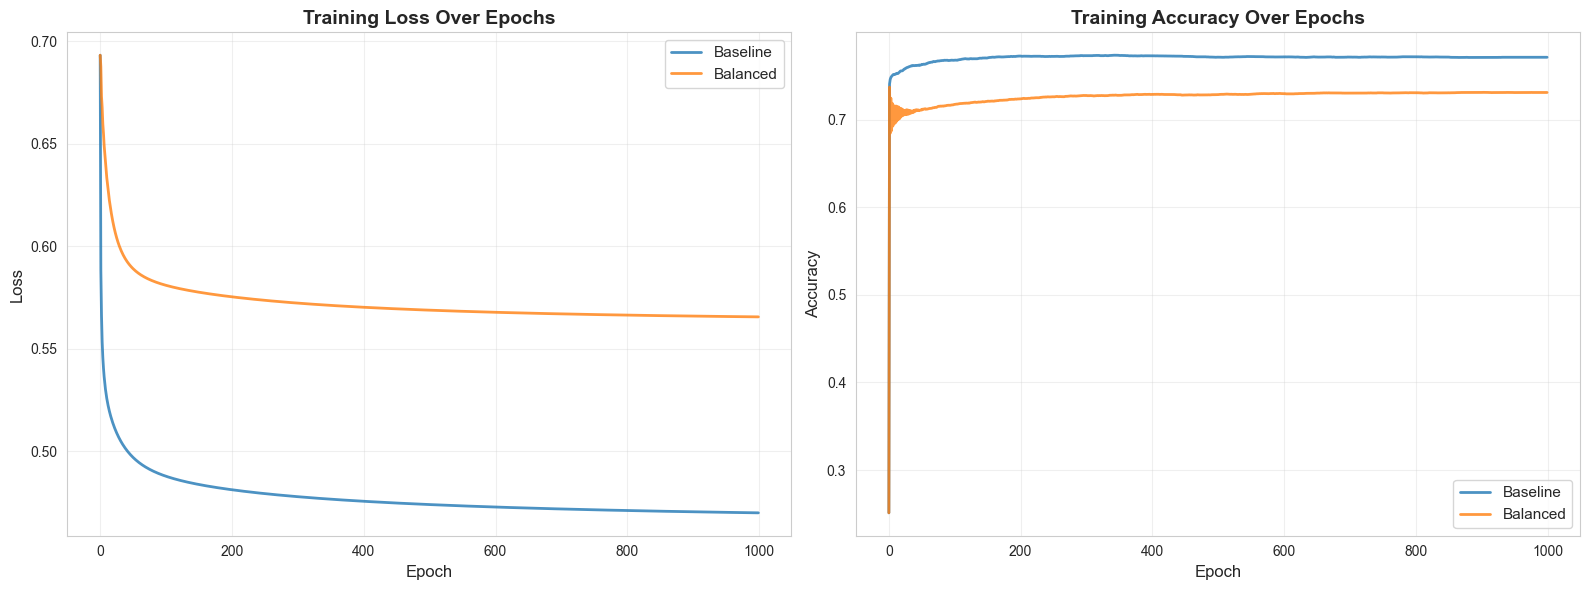

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Loss curves
axes[0].plot(baseline_model.history.losses, label='Baseline', linewidth=2, alpha=0.8)
axes[0].plot(balanced_model.history.losses, label='Balanced', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: Accuracy curves
axes[1].plot(baseline_model.history.accuracies, label='Baseline', linewidth=2, alpha=0.8)
axes[1].plot(balanced_model.history.accuracies, label='Balanced', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Metrics Comparison

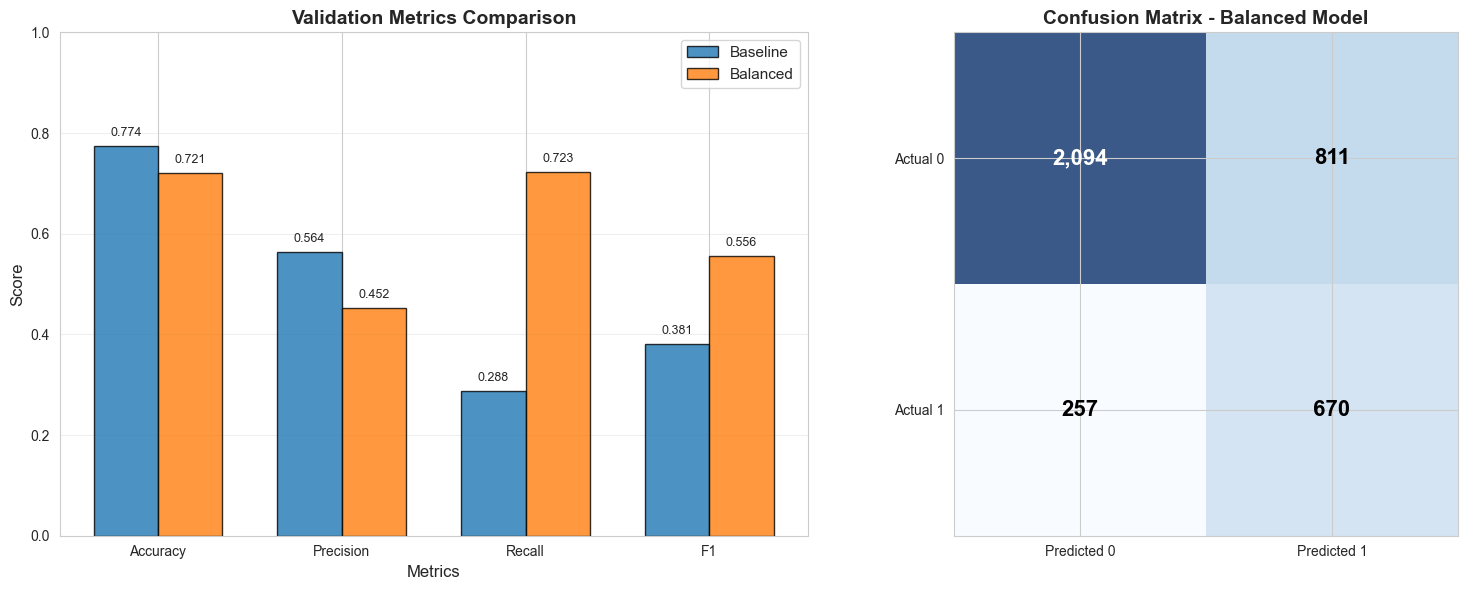

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics to compare (exclude log_loss for better visualization)
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
baseline_values = [val_metrics[m] for m in metrics_to_plot]
balanced_values = [val_metrics_bal[m] for m in metrics_to_plot]

x = np.arange(len(metrics_to_plot))
width = 0.35

# Plot 1: Bar chart comparison
axes[0].bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8, edgecolor='black')
axes[0].bar(x + width/2, balanced_values, width, label='Balanced', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Validation Metrics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.capitalize() for m in metrics_to_plot])
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 1)

# Add value labels on bars
for i, (bv, balv) in enumerate(zip(baseline_values, balanced_values)):
    axes[0].text(i - width/2, bv + 0.02, f'{bv:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, balv + 0.02, f'{balv:.3f}', ha='center', fontsize=9)

# Plot 2: Confusion Matrix for Balanced Model
def plot_confusion_matrix(y_true, y_pred, ax, title):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    im = ax.imshow(cm, cmap='Blues', alpha=0.8)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
    ax.set_yticklabels(['Actual 0', 'Actual 1'])
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{cm[i, j]:,}', ha='center', va='center', 
                          fontsize=16, fontweight='bold',
                          color='white' if cm[i, j] > cm.max() / 2 else 'black')
    
    return im

plot_confusion_matrix(y_val, val_preds_bal, axes[1], 'Confusion Matrix - Balanced Model')

plt.tight_layout()
plt.show()

## Dự đoán trên tập test

In [9]:
test_data = np.genfromtxt('../data/processed/test_processed.csv', 
                          delimiter=',', skip_header=1, dtype=str)

enrollee_ids = test_data[:, 0]
X_test = test_data[:, 1:].astype(float)
test_probs = balanced_model.predict_proba(X_test)
test_preds = balanced_model.predict(X_test)
submission = np.column_stack([enrollee_ids, test_preds.astype(int)])
output_path = '../outputs/submission.csv'

with open(output_path, 'w') as f:
    f.write('enrollee_id,target\n')
    for row in submission:
        f.write(f'{row[0]},{row[1]}\n')